# Assignment 1 - EigenFaces

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import matplotlib.pyplot as plt

In [2]:
# path if in local 
path = './archive/s*'

# path if in colab
# path = '/content/drive/MyDrive/Pattern/eigen-faces/archive/s*'

## 1. Download the Dataset and Understand the Format (10 Points)
## 2. Generate the Data Matrix and the Label vector (10 Points)

In [3]:
N = 10304
D = np.ones((1, N))

dirs = glob.glob(path)
y = np.array([])
for i, dir in enumerate(dirs, 1):
    for f in glob.glob(dir+"/*"):
        img = cv.imread(f, 0)
        img = np.reshape(img, (1, N))
        D = np.append(D, img, axis=0)
        y = np.append(y, i)

D = D[1:,]  # skip first row (1*N)


print(D.shape)
y = np.array(y)
print(y.shape)

(400, 10304)
(400,)


## 3. Split the Dataset into Training and Test sets (10 Points)

In [51]:
# training => odd
# testing => even
d_train, d_test = D[1::2], D[0::2]
y_train, y_test = y[1::2], y[0::2]


## 4. Classification using PCA (30 points)

In [31]:
d_train.shape

(200, 10304)

In [32]:
# compute mean
mean = np.mean(d_train,axis=0, keepdims=True)
print("Mean shape:", mean.shape)

# center data
Z = d_train - mean
print("Z shape:", Z.shape)

# compute covariance matrix
cov = np.cov(Z.T, bias=True)

# make sure covariance matrix is correct
# std = np.std(Z, axis=0)
# print("Covariance:", cov)
# print("Variance of each diagonal:", std * std)

# compute eigenvalues & eigenvectors
eival, eivec = np.linalg.eigh(cov)

# sort eigenval in descending order & corresponding eigenvec
idx = np.argsort(eival)[::-1]
eival = eival[idx]
eivec = eivec[:,idx]

# add eigenvalues until explained variance >= alpha
eival_sum = np.sum(eival)

Mean shape: (1, 10304)
Z shape: (200, 10304)


In [33]:
alphas = [0.8, 0.85, 0.9, 0.95]
proj_matrices = []
for alpha in alphas:
    # nominator of explained variance
    exp_var_nom = 0
    i = 0
    while(round(exp_var_nom/float(eival_sum), 2) < alpha and i < len(eival)-1):
        exp_var_nom += eival[i]
        i += 1
    print(i-1)
    proj_matrix = eivec[:, :i] # here we don't need to add 1 to i, since we post increment it
    proj_matrices.append(proj_matrix)

34
49
72
110


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(data_train, labels_train, data_test, labels_test, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_train, labels_train)
    
    # we can calculate accuracy either way
    
    # labels_pred = knn.predict(data_test)
    #accuracy = metrics.accuracy_score(labels_test, labels_pred)
    
    accuracy = knn.score(data_test, labels_test)
    
    return accuracy

In [35]:
scores = {}

org_accuracy = classify_knn(d_train, y_train, d_test, y_test, k=1)
print("Original accuracy:", org_accuracy)

for proj_matrix, alpha in zip(proj_matrices, alphas):
    d_train_new = np.dot(d_train, proj_matrix)
    d_test_new = np.dot(d_test, proj_matrix)
    
    accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=1)
    scores[alpha] = accuracy
       
print("Accuracy for each alpha:", scores)


Original accuracy: 0.965
Accuracy for each alpha: {0.8: 0.97, 0.85: 0.96, 0.9: 0.96, 0.95: 0.965}


## 5. Classification using LDA (30 points)

In [36]:
# calculate class means
means = np.ones((40, N))

class_matrices = []

for i in range(40):
    class_matrix = d_train[i*5:(i+1)*5,:]
    mean = np.mean(class_matrix, axis=0, keepdims=True)
    means[i] = mean
    class_matrices.append(class_matrix)

overall_mean = np.mean(d_train, axis=0, keepdims=True)
#print(means)

In [37]:
# calculate between-class scatter matrix
nk = 5
Sb = np.zeros((N, N))
for i, mean in enumerate(means):
    mean = mean.reshape(N, 1)
    overall_mean = overall_mean.reshape(N, 1)
    Sb += nk * np.dot((mean - overall_mean), (mean - overall_mean).T)

In [38]:
# calculate center class matrics
Zs = []
for i in range(40):
    Z = class_matrices[i] - means[i]
    Zs.append(Z)

In [39]:
Ss = np.zeros((N,N))
print(Ss.shape)
# calculate class scatter matrices

for i in range(40):
    Si = np.dot(Zs[i].T,Zs[i])
    Ss +=Si
Ss_inv = np.linalg.inv(Ss)
w, v = np.linalg.eigh(np.dot(Ss_inv,Sb))

# using 39 dominant eigen vectors
idx = w.argsort()[::-1][:39]
w = w[idx]
v = v[:,idx]
print(w.shape)
print(v.shape)


(10304, 10304)
(39,)
(10304, 39)


## 6. Classifier Tuning (20)

a. Set the number of neighbors in the K-NN classifier to 1,3,5,7.

**Tie breaking:**

* We left tie breaking to the default sklearn tie breaking strategy of KNeighborsClassifier

From the documentation for KNeighborsClassifier:

"Warning: Regarding the Nearest Neighbors algorithms, if it is found that two neighbors, neighbor k+1 and k, have identical distances but but different labels, the results will depend on the ordering of the training data."

So, in the case of ties, the answer will be the class that happens to appear first in the set of neighbors.

### 6. 1 PCA Tuning

In [40]:
Ks = [1, 3, 5, 7]

scores = {}

for k in Ks:
    scores_per_k = {}
    for proj_matrix, alpha in zip(proj_matrices, alphas):
        d_train_new = np.dot(d_train, proj_matrix)
        d_test_new = np.dot(d_test, proj_matrix)
        accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=k)
        scores_per_k[alpha] = accuracy
    scores[k] = scores_per_k
    print("K =", k)
    print(scores[k])
    print("\n")


K = 1
{0.8: 0.97, 0.85: 0.96, 0.9: 0.96, 0.95: 0.965}


K = 3
{0.8: 0.91, 0.85: 0.92, 0.9: 0.915, 0.95: 0.91}


K = 5
{0.8: 0.825, 0.85: 0.82, 0.9: 0.825, 0.95: 0.83}


K = 7
{0.8: 0.8, 0.85: 0.795, 0.9: 0.77, 0.95: 0.75}




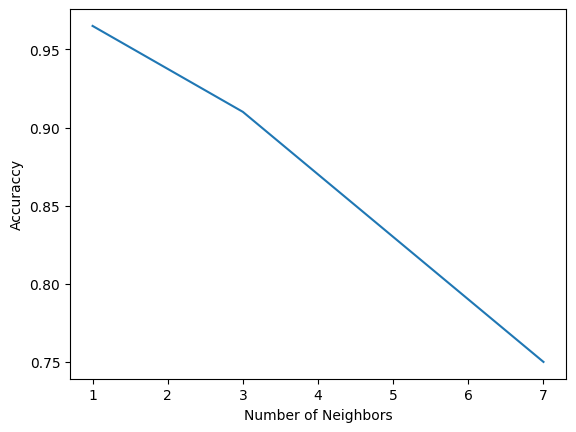

In [41]:
# plotting
max_accs = []

for k in scores:
    max_alpha = max(scores[k])
    max_acc = scores[k][max_alpha]
    max_accs.append(max_acc)
    
plt.plot(Ks, max_accs)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuraccy")
plt.show()

### 6.2 LDA Tuning

In [42]:
# Ks = [1, 3, 5, 7]
def project(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    
    return np.dot(w,x.T).T
# print(v.shape)
d_train_new = project(d_train,v.T)
d_test_new = project(d_test,v.T)
print(d_train_new.shape)
print(d_test_new.shape)

accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=1)
print(f"accuracy: {accuracy}")

(200, 39)
(200, 39)
accuracy: 0.945


In [43]:
scores = {}
kk = []


for k in Ks:
    scores_per_k = {}
    accuracy = classify_knn(d_train_new, y_train, d_test_new, y_test, k=k)
    print(f"accuracy: {accuracy}")
    scores[k] = accuracy
    kk.append(accuracy)
scores

accuracy: 0.945
accuracy: 0.905
accuracy: 0.775
accuracy: 0.71


{1: 0.945, 3: 0.905, 5: 0.775, 7: 0.71}

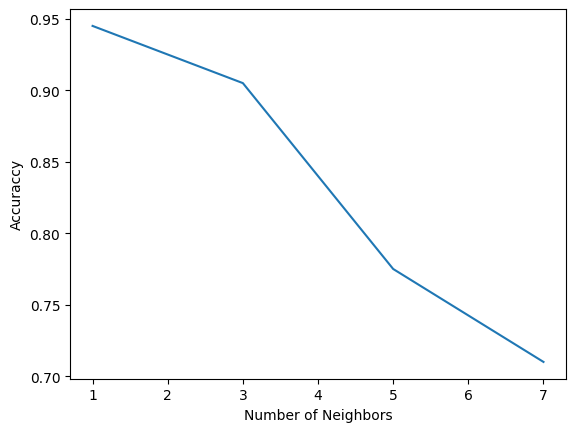

In [44]:
plt.plot(Ks,kk)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuraccy")
plt.show()

### Observations:

PCA performs better in case where number of samples per class is less. Whereas LDA works better with large dataset having multiple classes; class separability is an important factor while reducing dimensionality.

## 7. Compare with Non-face images (15 points)

### Load Dataset

In [5]:
# Load non-faces equal in count to faces (200 train, 200 test)
# Labels: 1 --> Face, 0 --> Non-face

non_face_path = './non_faces' 
N = 10304
d_non = np.ones((1, N))

y_non = np.array([])
i = 0
temp_img = np.array([92, 112])

for f in glob.glob(non_face_path+"/*"):
    if i == 400:
        break
    img = cv.imread(f, 0)
    temp_img = img[:92, :112]
    img = temp_img
    img = np.reshape(img, (1, N))
    d_non = np.append(d_non, img, axis=0)
    y_non = np.append(y_non, 0)
    i+=1

d_non = d_non[1:,]  # skip first row (1*N)


print(d_non.shape)
y_non = np.expand_dims(np.array(y_non), 1)
print(y_non.shape)

(400, 10304)
(400, 1)


In [12]:
y1 = np.ones((400,1))
print(y1.shape)

(400, 1)


In [13]:
# Non-face array w/ labels
non_faces = np.append(d_non, y_non, axis=1)
faces = np.append(D, y1, axis=1)
print(non_faces.shape)
print(faces.shape)

data = np.append(non_faces, faces, axis=0)
print(data.shape)
d2 = data[:, :10304]
y2 = data[:,10304]

print(d2.shape)
print(y2.shape)

(400, 10305)
(400, 10305)
(800, 10305)
(800, 10304)
(800,)


In [16]:
# separate into training & testing (one odd, one even)
# training => odd
# testing => even
d2_train, d2_test = d2[1::2], d2[0::2]
y2_train, y2_test = y2[1::2], y2[0::2]

print(d2_train.shape)

(400, 10304)


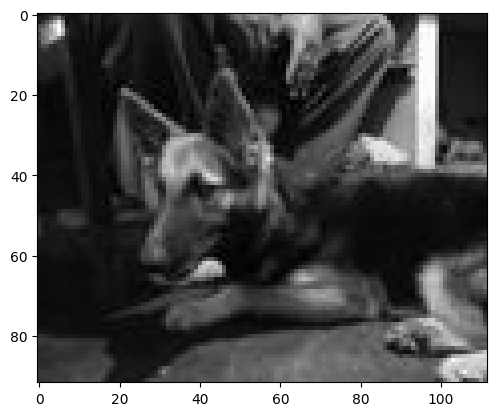

In [23]:
img = d2_train[48]
img = np.reshape(img, (92, 112))

plt.imshow(img, cmap='gray')
plt.show()


### PCA

In [18]:
from PCA import PCA

alphas = [0.8, 0.85, 0.9, 0.95]
scores = {}
pca = PCA()
pca._fit(d2_train)
print("Done fitting!")

Done fitting!


In [19]:
for alpha in alphas:
    pca.set_alpha(alpha)
    pca.fit(d2_train)
    d2_train_new = pca.transform(d2_train)
    d2_test_new = pca.transform(d2_test)
    
    accuracy = classify_knn(d2_train_new, y2_train, d2_test_new, y2_test, k=1)
    scores[alpha] = accuracy
    
scores

27
28
45
46
77
78
140
141


{0.8: 0.9975, 0.85: 0.9975, 0.9: 0.995, 0.95: 0.9975}

### LDA

### Accuracy vs. Number of non-face images

In [ ]:
# Plot the accuracy vs the number of non-face images while fixing 
# the number of face images.

# 50-50 Training so # of training samples = # testing samples

# number to try:
numbers = [200, 300, 400, 500, 600, 700]
datasets_train = {}
datasets_test = {}
ys_train = {}
ys_test = {}

# Reload data 

for num in numbers:
    d_non = np.ones((1, N))
    y_non = np.array([])
    i = 0
    temp_img = np.array([92, 112])
    for f in glob.glob(non_face_path+"/*"):
        if i == num:
            break
        img = cv.imread(f, 0)
        temp_img = img[:92, :112]
        img = temp_img
        img = np.reshape(img, (1, N))
        d_non = np.append(d_non, img, axis=0)
        y_non = np.append(y_non, 0)
        i+=1

    d_non = d_non[1:,]  # skip first row (1*N)
    y_non = np.expand_dims(np.array(y_non), 1)
    y1 = np.ones((400,1))
    # put faces & non faces together
    non_faces = np.append(d_non, y_non, axis=1)
    faces = np.append(D, y1, axis=1)

    data = np.append(non_faces, faces, axis=0)
    d2 = data[:, :10304]
    y2 = data[:,10304]
    
    d2_train, d2_test = d2[1::2], d2[0::2]
    y2_train, y2_test = y2[1::2], y2[0::2]
    
    datasets_train[num] = d2_train
    datasets_test[num] = d2_test
    ys_train[num] = y2_train
    ys_test[num] = y2_test
    


In [ ]:
# USE CONSTANT ALPHA FOR PCA = 0.95

# PCA

alpha = 0.95
pca_accuracies = {}
lda_accuracies = {}

for num in numbers:
    d2_train = datasets_train[num]
    d2_test = datasets_test[num]
    y2_train = ys_train[num]
    y2_test =  ys_test[num]
    
    pca = PCA()
    pca._fit(d2_train)
    pca.set_alpha(alpha)
    pca.fit(d2_train)
    d2_train_new = pca.transform(d2_train)
    d2_test_new = pca.transform(d2_test)
    
    accuracy = classify_knn(d2_train_new, y2_train, d2_test_new, y2_test, k=1)
    pca_accuracies[num] = accuracy
    
    
    #TODO: CODE LDA 
    ################
    accuracy = None # replace with actual accuracy
    lda_accuracies[num] = accuracy



## 8. Bonus (5 points)

### PCA & LDA

### Non-faces vs Faces

In [ ]:
# 70-30 Training so # of training samples = 3/7 * # of testing samples
# train numbers to try:
train_numbers = [200, 250, 300, 350, 400, 450]
test_numbers = [85, 107, 128, 150, 171, 192]